In [ ]:
import sys, subprocess, importlib

def need(mod):
    try:
        importlib.import_module(mod); return False
    except Exception:
        return True

to_install = []
for mod, pkg in [
    ("numpy", "numpy<2"),
    ("torch", "torch"),
    ("torchvision", "torchvision"),
    ("PIL", "pillow"),
    ("matplotlib", "matplotlib"),
]:

    if need(mod):
        to_install.append(pkg)

if to_install:
    print("Instalando:", to_install)
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + to_install)
    except Exception as e:
        if any(p in ("torch","torchvision") for p in to_install):
            print("Fallo instalación acelerada; probando ruedas CPU…")
            subprocess.check_call([
                sys.executable, "-m", "pip", "install", "-q",
                "torch", "torchvision", "--index-url", "https://download.pytorch.org/whl/cpu"
            ])
        else:
            raise e

import numpy as np, torch, torchvision, PIL, matplotlib
print("PyTorch:", torch.__version__, "| NumPy:", np.__version__)


PyTorch: 2.8.0+cu129


In [34]:
import sys, json
from pathlib import Path
import torch
from PIL import Image, ImageOps
from torchvision import transforms

BASE   = Path(".").resolve()
SRC    = BASE / "src"
MODELS = BASE / "models"
IMAGES = BASE / "images"
sys.path.append(str(BASE))

from src.model import ResNet18
from src.data  import MEAN, STD

DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 320
TFM = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

BUNDLE_PTH = MODELS / "maize_two_stage.pth"
assert BUNDLE_PTH.exists(), "❌ Falta models/maize_two_stage.pth"
print("Device:", DEVICE)


Device: cuda


In [2]:
def load_bundle(pth: Path, device=DEVICE):
    ckpt = torch.load(str(pth), map_location=device)

    c1, tau1 = ckpt["classes1"], ckpt.get("tau1")
    c2, tau2 = ckpt["classes2"], ckpt.get("tau2")

    m1 = ResNet18(num_classes=len(c1)).to(device).eval()
    m2 = ResNet18(num_classes=len(c2)).to(device).eval()
    m1.load_state_dict(ckpt["stage1"], strict=False)
    m2.load_state_dict(ckpt["stage2"], strict=False)
    return m1, m2, c1, tau1, c2, tau2

M1, M2, CLASSES1, TAU1, CLASSES2, TAU2 = load_bundle(BUNDLE_PTH)
print("Stage1:", CLASSES1, "| tau:", TAU1)
print("Stage2:", CLASSES2, "| tau:", TAU2)

@torch.no_grad()
def infer_probs(model, pil_img):
    x = TFM(ImageOps.exif_transpose(pil_img).convert("RGB")).unsqueeze(0).to(DEVICE)
    p = torch.softmax(model(x), 1)[0].cpu().tolist()
    return p

def apply_tau_binary(probs, classes, tau, pos_class):
    if tau is None or len(classes) != 2 or pos_class not in classes:
        return classes[int(torch.tensor(probs).argmax().item())]
    pos = classes.index(pos_class)
    return pos_class if float(probs[pos]) >= float(tau) else classes[1 - pos]

def run_pipeline(pil_img):
    p1 = infer_probs(M1, pil_img)
    pred1 = apply_tau_binary(p1, CLASSES1, TAU1, pos_class="maize")
    st1 = {"pred": pred1, "probs": dict(zip(CLASSES1, map(float, p1))), "tau": TAU1}
    if pred1 != "maize":
        return {"ok": True, "final": "not_maize", "stage1": st1}

    p2 = infer_probs(M2, pil_img)
    pred2 = apply_tau_binary(p2, CLASSES2, TAU2, pos_class="tizon_foliar")
    st2 = {"pred": pred2, "probs": dict(zip(CLASSES2, map(float, p2))), "tau": TAU2}
    return {"ok": True, "final": pred2, "stage1": st1, "stage2": st2}


Stage1: ['maize', 'not_maize'] | tau: 0.272
Stage2: ['healthy', 'tizon_foliar'] | tau: 0.395


In [3]:
# Si estás en Colab, permite subir un archivo y lo infiere.
try:
    from google.colab import files  # ignora si no estás en Colab
    up = files.upload()             # sube 1 imagen
    for name in up.keys():
        img = Image.open(name)
        out = run_pipeline(img)
        print(json.dumps({"img": name, **out}, ensure_ascii=False, indent=2))
except Exception as e:
    print("UI de subida no disponible (no estás en Colab):", e)


UI de subida no disponible (no estás en Colab): No module named 'google'


In [ ]:
from glob import glob, iglob

exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp","*.tif","*.tiff")
paths = [p for ext in exts for p in iglob(str(IMAGES/ext))]
paths = sorted(paths)

if not paths:
    print(f"⚠️ No hay imágenes en {IMAGES}. Coloca 3–5 para demo.")
else:
    print(f"Procesando {len(paths)} imágenes de {IMAGES}...\n")

rows = []
for p in paths:
    try:
        img = Image.open(p)
        out = run_pipeline(img)
        line = json.dumps({"img": p, **out}, ensure_ascii=False)
        print(line)              
        rows.append({"img": p, **out})
    except Exception as e:
        rows.append({"img": p, "ok": False, "error": str(e)})

with open("results.json", "w", encoding="utf-8") as f:
    json.dump(rows, f, ensure_ascii=False, indent=2)

print("\n✅ Guardado results.json")


Procesando 34 imágenes de C:\dev\notebook\images...

{"img": "C:\\dev\\notebook\\images\\000000545849.jpg", "ok": true, "final": "not_maize", "stage1": {"pred": "not_maize", "probs": {"maize": 0.02160617895424366, "not_maize": 0.9783938527107239}, "tau": 0.272}}
{"img": "C:\\dev\\notebook\\images\\000000552929.jpg", "ok": true, "final": "not_maize", "stage1": {"pred": "not_maize", "probs": {"maize": 0.02274364046752453, "not_maize": 0.9772562980651855}, "tau": 0.272}}
{"img": "C:\\dev\\notebook\\images\\000000553542.jpg", "ok": true, "final": "not_maize", "stage1": {"pred": "not_maize", "probs": {"maize": 0.02046787552535534, "not_maize": 0.9795320630073547}, "tau": 0.272}}
{"img": "C:\\dev\\notebook\\images\\000000555156.jpg", "ok": true, "final": "not_maize", "stage1": {"pred": "not_maize", "probs": {"maize": 0.01967504806816578, "not_maize": 0.980324923992157}, "tau": 0.272}}
{"img": "C:\\dev\\notebook\\images\\000000567916.jpg", "ok": true, "final": "not_maize", "stage1": {"pred": 

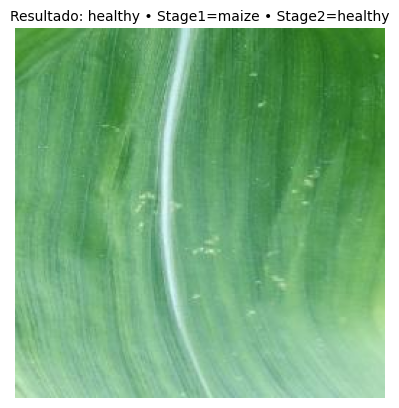

In [31]:
import random, matplotlib.pyplot as plt
from PIL import Image

if paths:
    p = random.choice(paths)       
    img = Image.open(p)
    res = run_pipeline(img)

    plt.imshow(img); plt.axis("off")
    ttl = f"Resultado: {res['final']} • Stage1={res['stage1']['pred']}"
    if 'stage2' in res and res['stage2'] is not None:
        ttl += f" • Stage2={res['stage2']['pred']}"
    plt.title(ttl , fontsize=10)   
    plt.show()
else:
    print("⚠️ No hay imágenes en 'images/'.")
